In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

sigmas=pd.read_csv('sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv('returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv('volumes.csv.gz',index_col=0,parse_dates=[0])
a = pd.read_csv('a.csv.gz',index_col=0,parse_dates=[0])
b = pd.read_csv('b.csv.gz',index_col=0,parse_dates=[0])
s = pd.read_csv('s.csv.gz',index_col=0,parse_dates=[0])

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

return_estimate=pd.read_csv('return_estimate.csv.gz',index_col=0,parse_dates=[0])
volume_estimate=pd.read_csv('volume_estimate.csv.gz',index_col=0,parse_dates=[0])
sigma_estimate=pd.read_csv('sigma_estimate.csv.gz',index_col=0,parse_dates=[0])

alpha_model = cp.AlphaSource(return_estimate)
optimization_tcost=cp.TcostModel(volume_estimate, sigma_estimate, a, b, cash_key='USDOLLAR')
optimization_hcost=cp.HcostModel(s, cash_key='USDOLLAR')

risk_data = pd.HDFStore('risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)

results={}

## Simulations

In [2]:
gamma_tcost=100.
policies={}
for lev in [1,2,3]:
    for risk in [ 30., 100., 300., 1000.] : 
        policies[(risk, lev)] = \
                cp.SinglePeriodOpt(alpha_model, [risk*risk_model, gamma_tcost*simulated_tcost, simulated_hcost], 
                                [cp.LeverageLimit(lev)])

results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [3]:
result_df=pd.DataFrame()
for k in results:
    result_df.loc[k[0], float(k[1])]= results[k]
result_df.index.name = 'gamma_risk'
result_df.columns.name = 'leverage'
result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))

In [4]:
used_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)]
benchmark_returns = pd.Series(index=used_returns.index, data=used_returns.USDOLLAR)

result_df_used= result_df

table=pd.DataFrame()
table[r'Excess return']=\
result_df_used.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Excess risk']= \
    result_df_used.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
table[r'Transaction costs']=\
    result_df_used.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()
    
# avg_daily_return=lambda res: "%.2f%%"%(res.mean_return*100)
# avg_annual_tcost=lambda res: "%.2f%%"%((res.simulator_TcostModel.sum(1)/res.v).mean() *250*100)
# volatility=lambda res: "%.2f%%"%(res.volatility*100)

# table=pd.Panel({r'Return':result_df_used.applymap(avg_daily_return),
#           r'Trans. costs':result_df_used.applymap(avg_annual_tcost),
#           r'Volatility':result_df_used.applymap(volatility),
#                }).to_frame()
table = table.set_index(table.index.rename([ r'$L^\mathrm{max}$',r'$\gamma^\mathrm{risk}$',]))

# format index
table=table.set_index(table.index.set_levels([["%g"%i for i in table.index.levels[0]],
                      ["%g"%i for i in table.index.levels[1]]]))

table_print=pd.DataFrame(table,copy=True)
table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )
print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

\begin{tabular}{lllll}
\toprule
  &     & Excess return & Excess risk & Transaction costs \\
$L^\mathrm{max}$ & $\gamma^\mathrm{risk}$ &               &             &                   \\
\midrule
1 & 30 &        31.42\% &      16.99\% &            27.19\% \\
  & 100 &        29.47\% &      15.75\% &            26.81\% \\
  & 300 &        27.34\% &      13.97\% &            25.00\% \\
  & 1000 &        22.48\% &       8.69\% &            18.10\% \\
2 & 30 &        31.83\% &      19.30\% &            51.41\% \\
  & 100 &        29.87\% &      17.53\% &            51.39\% \\
  & 300 &        29.33\% &      14.79\% &            50.26\% \\
  & 1000 &        27.32\% &       8.99\% &            43.97\% \\
3 & 30 &        29.07\% &      22.80\% &            69.57\% \\
  & 100 &        26.97\% &      20.39\% &            70.46\% \\
  & 300 &        27.74\% &      16.17\% &            69.61\% \\
  & 1000 &        26.68\% &       9.95\% &            62.13\% \\
\bottomrule
\end{tabular}



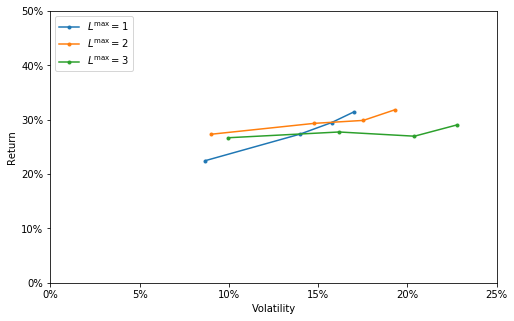

In [6]:
# plt.figure(figsize=(8,5))
# for leverage in result_df.columns:
#     x = [100*result_df.loc[(i, leverage)].volatility for i in result_df.index]
#     y = [100*result_df.loc[(i, leverage)].mean_return for i in result_df.index]
#     plt.plot(np.array(x),np.array(y), '.-', label=r'$L^\mathrm{max} = %g$'%leverage)
# plt.legend(loc='upper left')
# plt.xlabel('Volatility')
# plt.ylabel('Return')

plt.figure(figsize=(8,5))
for leverage in table.index.levels[0][:]:
    x = table.loc[leverage]['Excess risk']
    y = table.loc[leverage]['Excess return']
    plt.plot(np.array(x),np.array(y), '.-', label=r'$L^\mathrm{max} = %s$'%leverage)
plt.legend(loc='upper left')
plt.xlabel('Volatility')
plt.ylabel('Return')

#plt.xlim([4,24])
#plt.ylim([0,35])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%g%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%g%%'))

#plt.xlim([4,23])
plt.ylim([0,50])
plt.xlim([0,25])

plt.savefig(plotdir+'constr_riskrewardfrontier.png')

In [34]:
# x = [results_s.loc[l].volatility*100 for l in results_s.index]
# y = [results_s.loc[l].mean_return*100 for l in results_s.index]
# plt.plot(np.array(x),np.array(y), '.-')

In [35]:
result_df[1.]

gamma_risk
30.0      <cvx_portfolio.result.SimulationResult object ...
100.0     <cvx_portfolio.result.SimulationResult object ...
300.0     <cvx_portfolio.result.SimulationResult object ...
1000.0    <cvx_portfolio.result.SimulationResult object ...
Name: 1.0, dtype: object

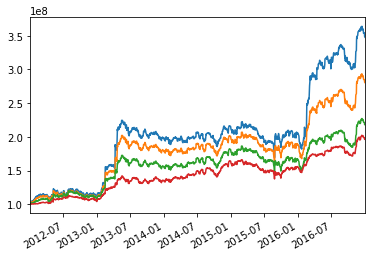

In [36]:
for res in result_df[1.]:
    res.v.plot()

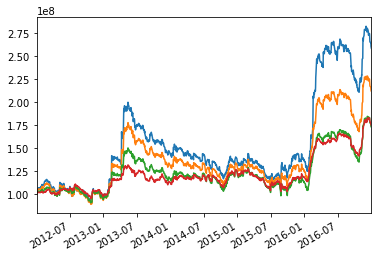

In [37]:
for res in result_df[2.]:
    res.v.plot()

In [ ]:
# for i in range(5):\
#     results_s.values[i].v.plot(label='%g'%leverages[i])
# plt.legend()

In [ ]:
# for i in range(5):\
#     results_s.values[i].w['USDOLLAR'].plot(label='%g'%leverages[i])
# plt.legend()

In [ ]:
# for i in range(5):\
#     (np.sqrt(250)*np.sqrt(results_s.values[i].policy_FactorModelSigma)).plot(label='%g'%leverages[i])
# plt.legend()